## 1. Business understanding

## 2. Data Understanding

In [129]:
# loading libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from nltk import FreqDist

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
# loading and previewing data

data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Describing the dataset

In [44]:
# class to describe dataset

class Describer:
    
    # initialize object
    def __init__(self, df):
        self.df = df
        
    # method to check shape of data
    def shape(self):
        out = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return out
    
    # method to check info on dataset
    def data_info(self):
        out = print(self.df.info(), '\n')
        return out
    
    # method to describe numerical columns
    def data_describe(self):
        out = self.df.describe()
        return out

In [45]:
# creating an instance of the class describer
describe_df = Describer(data)

# lets view the shape of the data
describe_df.shape()

The DataFrame has:
	* 9093 rows
	* 3 columns 



In [46]:
# lets print summary infomation on the dataset
print('Summary infomation on dataset')
print('-----------------------------------------------')
describe_df.data_info()

Summary infomation on dataset
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None 



### summary of data understanding

## 3. Data Preparation 

In [47]:
# intro

### missing values

In [48]:
# function to identify missing values

# identify missing 
def identify_missing_values(data):
    """Identify is the data has missing values"""
    # identify if data has missing values(data.isnull().any())
    # empty dict to store missing values
    missing = []
    for i in data.isnull().any():
        # add the bool values to empty list 
        missing.append(i)
    # covert list to set (if data has missing value, the list should have true and false)
    missing_set = set(missing)
    if (len(missing_set) == 1):
        out = print("The Data has no missing values")
    else:
        out = print("The Data has missing values.")

    return out

identify_missing_values(data)

The Data has missing values.


In [49]:
# function to display missing values

def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data)).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage(%)": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage(%)"] == 0].index, inplace = True)

    return missing


missing_values(data)


,Missing Values,Percentage(%)
emotion_in_tweet_is_directed_at,5802,0.638073
tweet_text,1,0.000110


In [50]:
# dropping missing row in tweet_text

data.dropna(axis=0,subset=['tweet_text'],inplace=True)

In [51]:
# confirmation

data.isna().any()

tweet_text                                            False
emotion_in_tweet_is_directed_at                        True
is_there_an_emotion_directed_at_a_brand_or_product    False
dtype: bool

In [52]:
# replacing null values in recipient with nan

data['emotion_in_tweet_is_directed_at'].fillna('none', inplace =True)

In [53]:
data['emotion_in_tweet_is_directed_at'].value_counts()

none                               5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [54]:
data.isna().any()

tweet_text                                            False
emotion_in_tweet_is_directed_at                       False
is_there_an_emotion_directed_at_a_brand_or_product    False
dtype: bool

In [55]:
# justification

### Duplicates

In [56]:
# checking for duplicates

# Duplicated entries
def identify_duplicates(data):
    """Simple function to identify any duplicates"""
    # identify the duplicates (dataframename.duplicated() , can add .sum() to get total count)
    # empty list to store Bool results from duplicated
    duplicates = []
    for i in data.duplicated():
        duplicates.append(i)
    # identify if there is any duplicates. (If there is any we expect a True value in the list duplicates)
    duplicates_set = set(duplicates) 
    if (len(duplicates_set) == 1):
        print("The Data has no duplicates")
    else:
        no_true = 0
        for val in duplicates:
            if (val == True):
                no_true += 1
        # percentage of the data represented by duplicates 
        duplicates_percentage = np.round(((no_true / len(data)) * 100), 3)
        print(f"The Data has {no_true} duplicated rows.\nThis constitutes {duplicates_percentage}% of the data set.") 



identify_duplicates(data)

The Data has 22 duplicated rows.
This constitutes 0.242% of the data set.


In [57]:
data.duplicated().sum()

22

In [58]:
# handling the duplicates 
def remove_duplicated_rows(data):
    """Simple Function to remove duplicated rows"""
    data.drop_duplicates(subset=None, keep="first", inplace=True)
    # confirm if the duplicated rows have been removed
    confirm = identify_duplicates(data)

    return confirm 


remove_duplicated_rows(data)

The Data has no duplicates


In [59]:
# renaming the columns
data = data.rename(columns={'emotion_in_tweet_is_directed_at':'recipient',
                    'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'})
data.head()

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion



## 4. EDA

In [60]:
# intro

### Univariate analysis


No emotion toward brand or product    59.261301
Positive emotion                      32.745314
Negative emotion                       6.273429
I can't tell                           1.719956
Name: emotion, dtype: float64


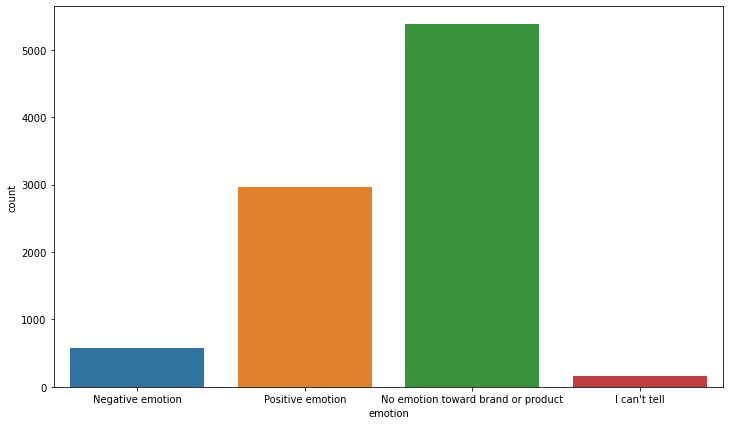

In [61]:
# checking the distribution of emotions

percentage = data['emotion'].value_counts(normalize=True)
print(percentage * 100)

# count plot
plt.figure(figsize=(12, 7))
sns.countplot(data['emotion']);

In [62]:
# interpretation

### Bivariate analysis

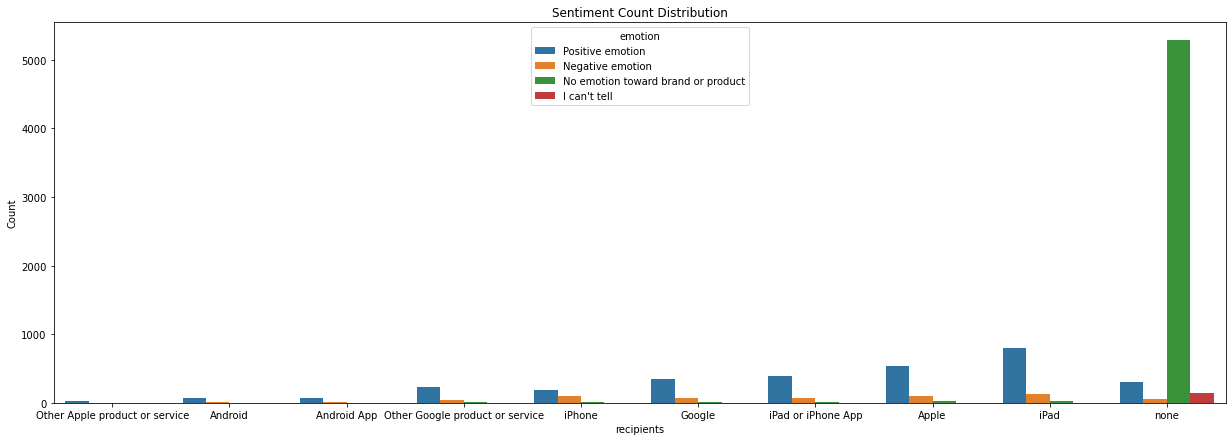

In [63]:
# lets see see sentiment distribution product-wise
recipient_group = data.groupby('recipient')['emotion'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = recipient_group.groupby('recipient')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='recipient', y='count', hue='emotion', data=recipient_group, order=ascending_order)
plt.xlabel('recipients')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

In [64]:
# interpretation

In [65]:
data['recipient'].value_counts()

none                               5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: recipient, dtype: int64

In [66]:
# overall brand distribution

# feature engineering
data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple', 
                                           'Android': 'Google',
                                           'Android App': 'Google',
                                           'Other Google product or service ': 'Google',
                                           'iPhone': 'Apple', 
                                           'Google':'Google',
                                           'iPad or iPhone App': 'Apple',
                                           'Apple':'Apple',
                                           'iPad':'Apple',
                                           'none': 'none'})



In [67]:
data.head(3)

,tweet_text,recipient,emotion,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple


none      65.945084
Apple     27.389769
Google     6.665148
Name: brand, dtype: float64


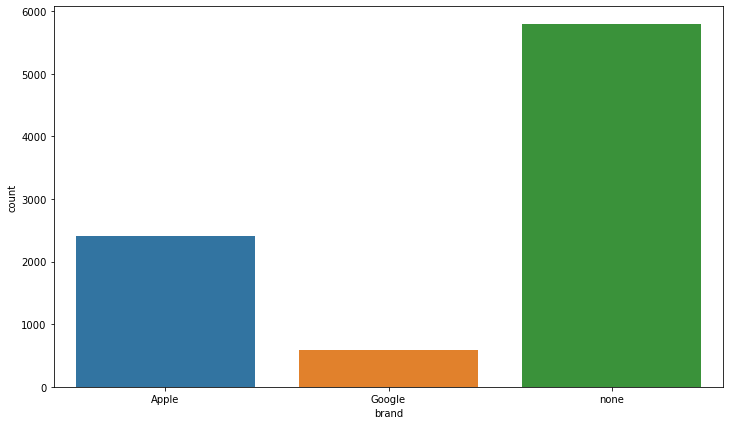

In [68]:
# checking the distribution of brand sentiment

percentage = data['brand'].value_counts(normalize=True)
print(percentage * 100)

# count plot
plt.figure(figsize=(12, 7))
sns.countplot(data['brand']);

In [69]:
# intepretation

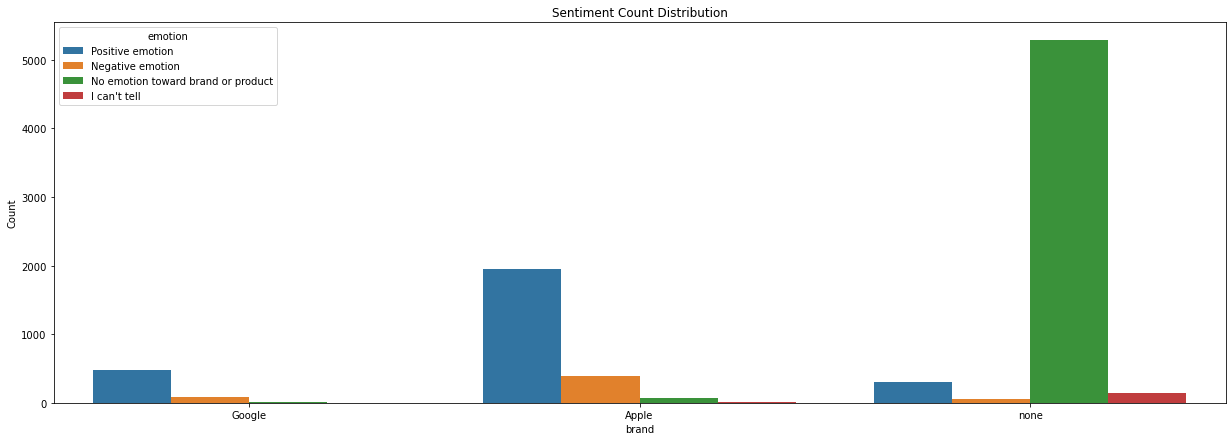

In [70]:
# lets see see sentiment distribution brand-wise
brand_group = data.groupby('brand')['emotion'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = brand_group.groupby('brand')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='brand', y='count', hue='emotion', data=brand_group, order=ascending_order)
plt.xlabel('brand')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

In [71]:
# intepretation

## 5. preprocessing

intro

In [72]:
data.columns

Index(['tweet_text', 'recipient', 'emotion', 'brand'], dtype='object')

In [73]:
# normalizing the data to lowecase
data['tweet_text'] = data['tweet_text'].str.lower()
data.head(2)

,tweet_text,recipient,emotion,brand
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,Apple


In [74]:
data['tweet_text'][14]

'great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l'

In [75]:
# removing the html tags
def remove_html(review):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', review)

data['tweet_text'] = data['tweet_text'].apply(remove_html)

In [76]:
# removing URL and @ sign

def preprocess_text_removingq_URLand_atsign(text):
    # Remove URLs
    clean_text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'@[^\s]+', 'user', clean_text)
    # Other preprocessing steps like removing punctuation, converting to lowercase, etc.
    # ...
    return text

data['tweet_text'] = data['tweet_text'].apply(preprocess_text_removingq_URLand_atsign)

In [77]:
data['tweet_text'][14]

'great #sxsw ipad app from user '

In [78]:
data.head()

,tweet_text,recipient,emotion,brand
0,.user i have a 3g iphone. after 3 hrs tweeting...,iPhone,Negative emotion,Apple
1,user know about user ? awesome ipad/iphone app...,iPad or iPhone App,Positive emotion,Apple
2,user can not wait for #ipad 2 also. they shoul...,iPad,Positive emotion,Apple
3,user i hope this year's festival isn't as cras...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff on fri #sxsw: marissa mayer (...,Google,Positive emotion,Google


In [80]:
# function to remove hash, not alphabet 

In [81]:
# expanding the contractions (is-nots)

import contractions
#from nltk.stem import WordNetLemmatizer

def expand(text):
    # Expand contractions
    expanded_text = contractions.fix(text)

    return expanded_text

data['tweet_text'] = data['tweet_text'].apply(expand)

In [82]:
data.tweet_text[3]

"user i hope this year's festival is not as crashy as this year's iphone app. #sxsw"

In [83]:
# punctuation
exclude = string.punctuation
print(exclude)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [84]:
# remove punctuations
def remove_punctuations(tweet):
    return tweet.translate(str.maketrans('','',exclude))

In [85]:
data['tweet_text']=data['tweet_text'].apply(remove_punctuations)
data.head()

,tweet_text,recipient,emotion,brand
0,user i have a 3g iphone after 3 hrs tweeting a...,iPhone,Negative emotion,Apple
1,user know about user awesome ipadiphone app t...,iPad or iPhone App,Positive emotion,Apple
2,user can not wait for ipad 2 also they should ...,iPad,Positive emotion,Apple
3,user i hope this years festival is not as cras...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff on fri sxsw marissa mayer goo...,Google,Positive emotion,Google


In [86]:
data.tweet_text[20]

'need to buy an ipad2 while i am in austin at sxsw not sure if i will need to q up at an austin apple store'

In [87]:
# tokenize the tweets
def tokenize_text(tweet):
    return word_tokenize(tweet)

data['tweet_text'] = data['tweet_text'].apply(tokenize_text)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, i, have, a, 3g, iphone, after, 3, hrs, ...",iPhone,Negative emotion,Apple
1,"[user, know, about, user, awesome, ipadiphone,...",iPad or iPhone App,Positive emotion,Apple
2,"[user, can, not, wait, for, ipad, 2, also, the...",iPad,Positive emotion,Apple
3,"[user, i, hope, this, years, festival, is, not...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, on, fri, sxsw, marissa, m...",Google,Positive emotion,Google


In [88]:
# removing stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(tweet):
    # Use list comprehension for efficient list creation
    new_tweet = [word for word in tweet if word not in stop_words]
    return " ".join(new_tweet)

# Apply the function to the 'review' column
data['tweet_text'] = data['tweet_text'].apply(remove_stopwords)
data.head()

,tweet_text,recipient,emotion,brand
0,user 3g iphone 3 hrs tweeting riseaustin dead ...,iPhone,Negative emotion,Apple
1,user know user awesome ipadiphone app likely a...,iPad or iPhone App,Positive emotion,Apple
2,user wait ipad 2 also sale sxsw,iPad,Positive emotion,Apple
3,user hope years festival crashy years iphone a...,iPad or iPhone App,Negative emotion,Apple
4,user great stuff fri sxsw marissa mayer google...,Google,Positive emotion,Google


In [89]:
data.emotion.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

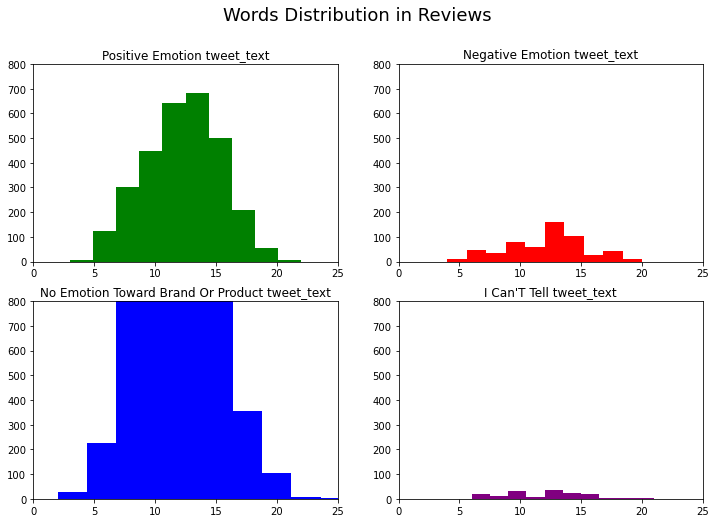

In [90]:
def generate_review_hist_plot(data, label, color, ax):
    tweet_len = data[data['emotion']==label].tweet_text.str.split().map(lambda x: len(x))
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 800)
    ax.hist(tweet_len, color=color)
    ax.set_title(f'{label.title()} tweet_text')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
generate_review_hist_plot(data,'Positive emotion','green',ax[0,0])
generate_review_hist_plot(data,'Negative emotion','red',ax[0,1])
generate_review_hist_plot(data,'No emotion toward brand or product','blue',ax[1,0])
generate_review_hist_plot(data,"I can't tell",'purple',ax[1,1])

fig.suptitle("Words Distribution in Reviews", fontsize=18)

plt.show()

In [91]:
# re-tokenizing the data

data['tweet_text'] = data['tweet_text'].apply(tokenize_text)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, 3g, iphone, 3, hrs, tweeting, riseausti...",iPhone,Negative emotion,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple
3,"[user, hope, years, festival, crashy, years, i...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google


In [92]:
data.tweet_text[0]

['user',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'riseaustin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [93]:
# justifications of retokenizing

### frequency distribution after removing stopwords

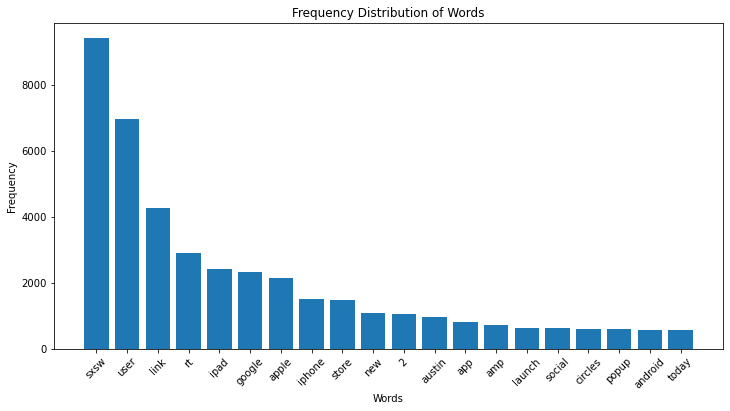

In [94]:
tweet_texts = data.tweet_text
# Flatten the list of tokens into a single list
all_tokens = [tweet for sublist in tweet_texts for tweet in sublist]

# Create the frequency distribution
freq_dist = FreqDist(all_tokens)

# Get the most common words
most_common = freq_dist.most_common(20)  # Example: Top 20 most common words

# Extract the words and frequencies
words, frequencies = zip(*most_common)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Words')
plt.xticks(rotation=45)
plt.show()

### write justification for why stopped words occurs above

In [95]:
# lemmatization

# Create Lemmatizer and Stemmer.
word_lem = WordNetLemmatizer()

# function
def lem_words(tweet):
    return [word_lem.lemmatize(word) for word in tweet]

In [96]:
data['tweet_text'] = data['tweet_text'].apply(lem_words)
data['tweet_text'].head()

0    [user, 3g, iphone, 3, hr, tweeting, riseaustin...
1    [user, know, user, awesome, ipadiphone, app, l...
2              [user, wait, ipad, 2, also, sale, sxsw]
3    [user, hope, year, festival, crashy, year, iph...
4    [user, great, stuff, fri, sxsw, marissa, mayer...
Name: tweet_text, dtype: object

#### dealing with emojis

In [97]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [98]:
def process(tweets):
    
    processed_tweet = []
    
    
    # Defining regex patterns.
    
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in tweets:
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])              
            # Replace 3 or more consecutive letters by 2 letter.
            tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        processed_tweet.append(tweet)
        
    return processed_tweet

In [99]:
data['tweet_text'] = data['tweet_text'].apply(process)
data.head()

,tweet_text,recipient,emotion,brand
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google


In [100]:
data.tweet_text[0]

['user',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'riseaustin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw']

In [113]:
data['target'] = data['brand'].astype(str)
data

,tweet_text,recipient,emotion,brand,lemmatized_review,target
0,"[user, 3g, iphone, 3, hr, tweeting, riseaustin...",iPhone,Negative emotion,Apple,user 3g iphone 3 hr tweeting riseaustin dead n...,Apple
1,"[user, know, user, awesome, ipadiphone, app, l...",iPad or iPhone App,Positive emotion,Apple,user know user awesome ipadiphone app likely a...,Apple
2,"[user, wait, ipad, 2, also, sale, sxsw]",iPad,Positive emotion,Apple,user wait ipad 2 also sale sxsw,Apple
3,"[user, hope, year, festival, crashy, year, iph...",iPad or iPhone App,Negative emotion,Apple,user hope year festival crashy year iphone app...,Apple
4,"[user, great, stuff, fri, sxsw, marissa, mayer...",Google,Positive emotion,Google,user great stuff fri sxsw marissa mayer google...,Google
...,...,...,...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",iPad,Positive emotion,Apple,ipad everywhere sxsw link,Apple
9089,"[wave, buzz, rt, user, interrupt, regularly, s...",none,No emotion toward brand or product,none,wave buzz rt user interrupt regularly schedule...,none
9090,"[google, zeiger, physician, never, reported, p...",none,No emotion toward brand or product,none,google zeiger physician never reported potenti...,none
9091,"[verizon, iphone, customer, complained, time, ...",none,No emotion toward brand or product,none,verizon iphone customer complained time fell b...,none


In [117]:
# Convert string labels to 1 or 0 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['target'] = le.fit_transform(data['target'])


# Examine our data
print(data.head())

# Separate features and labels 
X = data['lemmatized_review']
y = data['target']

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=1)

                                          tweet_text           recipient  \
0  [user, 3g, iphone, 3, hr, tweeting, riseaustin...              iPhone   
1  [user, know, user, awesome, ipadiphone, app, l...  iPad or iPhone App   
2            [user, wait, ipad, 2, also, sale, sxsw]                iPad   
3  [user, hope, year, festival, crashy, year, iph...  iPad or iPhone App   
4  [user, great, stuff, fri, sxsw, marissa, mayer...              Google   

            emotion   brand  \
0  Negative emotion   Apple   
1  Positive emotion   Apple   
2  Positive emotion   Apple   
3  Negative emotion   Apple   
4  Positive emotion  Google   

                                   lemmatized_review  target  
0  user 3g iphone 3 hr tweeting riseaustin dead n...       0  
1  user know user awesome ipadiphone app likely a...       0  
2                    user wait ipad 2 also sale sxsw       0  
3  user hope year festival crashy year iphone app...       0  
4  user great stuff fri sxsw marissa maye

# vectorization

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(max_features=10, stop_words=stop_words)

tf_idf_train = vectorizer.fit_transform(X_train)

tf_idf_test = vectorizer.transform(X_test)
#view 
pd.DataFrame.sparse.from_spmatrix(tf_idf_train, columns=vectorizer.get_feature_names())


,apple,google,ipad,iphone,link,new,rt,store,sxsw,user
0,0.767477,0.000000,0.000000,0.000000,0.558611,0.0,0.000000,0.0,0.314536,0.000000
1,0.000000,0.397999,0.000000,0.000000,0.000000,0.0,0.376461,0.0,0.169194,0.819297
2,0.000000,0.000000,0.919879,0.000000,0.000000,0.0,0.000000,0.0,0.392203,0.000000
3,0.691397,0.000000,0.664589,0.000000,0.000000,0.0,0.000000,0.0,0.283356,0.000000
4,0.000000,0.755770,0.000000,0.000000,0.570602,0.0,0.000000,0.0,0.321288,0.000000
...,...,...,...,...,...,...,...,...,...,...
4530,0.000000,0.920293,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.391229,0.000000
4531,0.000000,0.920293,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.391229,0.000000
4532,0.000000,0.000000,0.000000,0.883780,0.000000,0.0,0.355919,0.0,0.159962,0.258197
4533,0.000000,0.000000,0.501493,0.000000,0.000000,0.0,0.475749,0.0,0.213818,0.690253


### multinomial Naive Bayes classifier

In [130]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, tf_idf_train, y_train)
baseline_cv

array([0.64277839, 0.63616318, 0.64829107, 0.64277839, 0.64388093])

> How well is this model performing? Well, recall the class balance:


In [131]:
y_train.value_counts(normalize=True)

3    0.641235
0    0.268137
1    0.057552
2    0.033076
Name: target, dtype: float64

> If we guessed the plurality class every time (class 3), we would expect about 64% accuracy. So when this model is getting 63-64% accuracy, that is a clear improvement over just guessing. But with an accuracy above 50%, we still expect the model to guess the abit wrong class the majority of the time. Let's see if we can improve that with more sophisticated preprocessing.

In [124]:
classifier = RandomForestClassifier(random_state=1)

#Fit on training
classifier.fit(tf_idf_train,y_train)

# Predict using test    
y_preds = classifier.predict(tf_idf_test)

### Using Tokens 

use custom tokens so  that googling and google the modek reads it as the same thing 


In [132]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [133]:
#print outputs 
print("Original sample:", X_train.iloc[100]["tweet_text"][20:30])
print("Stemmed sample: ", stem_and_tokenize(X_train.iloc[100]["text"])[20:30])

TypeError: string indices must be integers

In [101]:
# create instance
bow = CountVectorizer()
data['lemmatized_review'] = data['tweet_text'].str.join(" ")
x = bow.fit_transform(data['lemmatized_review'])

In [102]:
feature_name = bow.get_feature_names_out()
feature_name

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [ ]:
# write observation of code above

### label encoding the target

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
data['emotion_code'] = le.fit_transform(data.emotion)
le.classes_

In [ ]:
data.head()

In [ ]:
# displaying the encoding scheme
data[['emotion', 'emotion_code']].head(10)

## binary classification

In [ ]:
data_copy = data.copy()

In [ ]:
# Define the values to drop
values_to_drop = [0, 2]

# Drop rows that have the values in column 'B'
data_copy = data_copy[~data_copy['emotion_code'].isin(values_to_drop)]

In [ ]:
data_copy['emotion_code'].value_counts()

In [ ]:
# lets see see binary sentiment distribution emotion-wise
emotion_group = data_copy.groupby('emotion')['emotion_code'].value_counts().reset_index(name='count')
# Calculate the ascending order of states based on churn count
ascending_order = emotion_group.groupby('emotion')['count'].sum().sort_values().index

plt.figure(figsize=(10,7))
sns.barplot(x='emotion', y='count', hue='emotion', data=emotion_group, order=ascending_order)
plt.xlabel('emotion')
plt.ylabel('Count')
plt.title('Sentiment Count Distribution')
plt.show()

In [ ]:
# intepretation

In [ ]:
# create instance
bow2 = CountVectorizer()
data_copy['lemmatized_review'] = data_copy['tweet_text'].str.join(" ")
x2 = bow2.fit_transform(data_copy['lemmatized_review'])

### Train-test split

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [ ]:
#x = bow.fit_transform(data['lemmatized_review'])
y = data_copy['emotion_code']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape

# Modelling

In [ ]:
# instantiating model 1
log_reg = LogisticRegression(random_state=42)

In [ ]:
log_reg.fit(X_train, y_train)

In [ ]:
y_pred = log_reg.predict(X_test)
y_train_pred = log_reg.predict(X_train)

In [ ]:
print('train',accuracy_score(y_train, y_train_pred))
print('test',accuracy_score(y_test, y_pred))

In [ ]:
# test model here